

#### 1. The Data

I used the data since 2020-05-01, which avoided the market crash in March 2020

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from datetime import timedelta
import scipy.optimize as sco

import eikon as ek

ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

In [23]:
symbols = ['SPY', 'VUKE.L', 'QQQ.O']
noa = len(symbols) # Number of financial instuments defined
fields = "CLOSE"
end_date = datetime.today()
start_date = "2020-05-01"
data = ek.get_timeseries(symbols, fields, start_date, end_date)
data.head()

CLOSE,SPY,VUKE.L,QQQ.O
Date,,,
2020-05-01,282.79,25.42,212.74
2020-05-04,283.57,25.36,215.22
2020-05-05,286.19,25.765,217.66
2020-05-06,284.25,25.77,219.0
2020-05-07,287.68,26.22,221.82


In [24]:
# Use log returns
rets = np.log(data / data.shift(1))

In [25]:
weights = np.random.random(noa) # Random portfolio weights
weights /= np.sum(weights) # normalized to 1 or 100%

#### 2. Defined porfolio return and porfolio risk function

In [26]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

#### 3. Monte Carlo Simulation to draw a heatmap based on different random weight allocation

In [27]:
prets = []
pvols = []
for p in range (2500):
    
    # Monte Carlo simulation of portfolio weights.
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    
    #Collects the resulting statistics in list objects.
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
    
prets = np.array(prets)
pvols = np.array(pvols)

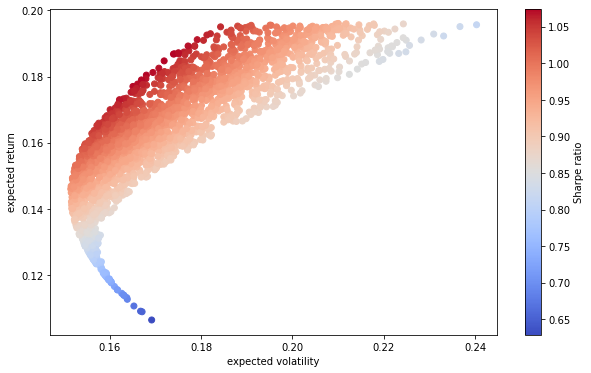

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

#### 4. Maximised the Sharpe ratio by minimising the negative Sharpe ratio using scipy library

First defining the function to be minimised:

In [29]:
# Function to be minimized.
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

In [30]:
# Equality constraint
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [31]:
# Bounds for the parameters.
bnds = tuple((0, 1) for x in range(noa))

In [32]:
# Equal weights vector.
eweights = np.array(noa * [1. / noa,])
eweights

array([0.33333333, 0.33333333, 0.33333333])

In [33]:
# The optimization (i.e., minimization of function min_func_sharpe())
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

In [34]:
# The results from the optimization.
opts

     fun: -1.075173087811899
     jac: array([-4.27663326e-05,  3.01152468e-04,  2.07497090e-01])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([8.75646353e-01, 1.24353647e-01, 3.92481186e-17])

In [35]:
# The optimal portfolio weights.
opts['x'].round(3)

array([0.876, 0.124, 0.   ])

In [36]:
# The resulting portfolio return
port_ret(opts['x']).round(3)

0.184

In [37]:
# The resulting portfolio volatility.
port_vol(opts['x']).round(3)

0.171

In [38]:
# The maximum Sharpe ratio.
port_ret(opts['x']) / port_vol(opts['x'])

1.075173087811899

The optimal portfolio indicates that a potential investor should invest in SPY and VUKE.L only and avoid investing in QQQ.O. It should be allocate 87.6% of investment into SPY and 12.4% into VUKE.L.

The Sharpe ratio based on the porfolio is 1.08 which means it's a very good investment. 

#### 5. Efficient Frontier

In [39]:
# The two binding constraints for the efficient frontier.
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, 
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [40]:
bnds = tuple((0, 1) for x in weights)

In [41]:
# The minimization of portfolio volatility for different target returns.
trets = np.linspace(0.15, 0.38, 100)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', 
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

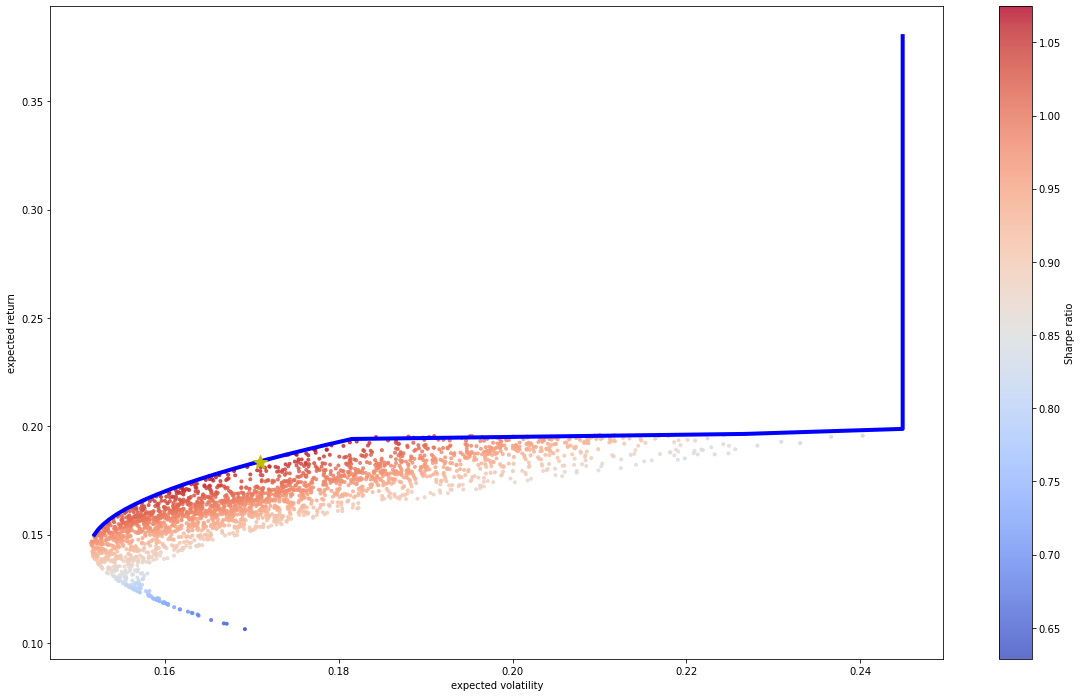

In [42]:
plt.figure(figsize=(20, 12))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')